In [4]:
cd /content/drive/MyDrive/Word-Similarity/problem

/content/drive/MyDrive/Word-Similarity/problem


In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from IPython.display import display
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Data manipulation
import pandas as pd
import numpy as np


# Splitting data
from sklearn.model_selection import train_test_split

In [7]:
from scipy import stats
from scipy import spatial
from gensim.models import KeyedVectors

In [8]:
word2vec = KeyedVectors.load_word2vec_format('../word2vec/W2V_150.txt', binary=False)      
#test embedding
print(word2vec['a_dua'])
import random
print(np.random.randn(150))

[-1.096853    0.1238883   1.713642    2.17519    -0.5785002  -2.027245
  0.4998034  -0.7409065  -1.753515   -1.095152    0.7456962   1.484329
  1.235524    1.025137   -0.4033328  -0.9089296  -0.2022127   0.9581299
  0.6957457   1.385916    0.4481485   1.238998    0.1075599   3.29651
  1.315556    0.4587597   2.277924   -1.313732    0.9624746  -0.2428055
 -0.9468833   0.8783497   0.3211554  -0.5890836   0.9027938  -1.178614
 -0.7399899  -1.011717    1.766519   -2.162154    0.9139196  -2.295288
 -1.206698   -2.222441   -1.830276   -0.4457759   1.122905    0.3227312
 -0.03411892 -0.7967375   0.1875879   0.3892174  -0.7192345  -0.5432259
 -0.6546717  -0.7268866   0.5100322   0.9201084   0.2751797   1.194452
  0.5092697  -0.3654743  -1.434594   -1.484043    1.105507    0.02227577
 -1.812047   -1.204937   -3.369251    0.6383803   0.1732161  -0.478294
 -0.5762202   0.1084443  -0.1128882   0.647718   -0.3459211   0.5320156
  0.239954   -2.538636   -0.7471865   1.441165    0.02344817 -0.9431902

In [9]:
class EmbGetter:
    def __init__(self, model):
        self.model = model
        self.emb_dim = model["a_dua"].shape[0]
    def get(self, s):
        if s in self.model:
            return self.model[s]
        else:
            return np.random.randn(self.emb_dim)
    def contains(self, s):
        return s in self.model
    
emb_getter = EmbGetter(word2vec)

In [10]:
def pearson(e1, e2):
    return stats.pearsonr(e1, e2)[0]

def spearman_rank(e1, e2):
    return stats.spearmanr(e1, e2)[0]

def dot_product(e1, e2):
    return np.dot(e1, e2)

def euclidean(e1, e2):
    return 1 - spatial.distance.euclidean(e1, e2)

def make_feature(input_table, drop_miss=False):
    features = input_table.copy()
    features['first_emb'] = features.apply(lambda row: emb_getter.get(row['Word1']), axis=1)
    features['second_emb'] = features.apply(lambda row: emb_getter.get(row['Word2']), axis=1)

    features['cos'] = features.apply(lambda row: 1 - spatial.distance.cosine(row['first_emb'], row['second_emb']), axis=1)
    features['norm_of_diff'] = features.apply(lambda row: np.linalg.norm(row['first_emb'] - row['second_emb']), axis=1)
    features['pearson'] = features.apply(lambda row: pearson(row['first_emb'], row['second_emb']), axis=1)
    features['spearman_rank'] = features.apply(lambda row: spearman_rank(row['first_emb'], row['second_emb']), axis=1)
    features['dot_product'] = features.apply(lambda row: dot_product(row['first_emb'], row['second_emb']), axis=1)
    features['euclidean'] = features.apply(lambda row: euclidean(row['first_emb'], row['second_emb']), axis=1)


    df1 = pd.DataFrame(features['first_emb'].values.tolist())
    df2 = pd.DataFrame(features['second_emb'].values.tolist())
    df3 = pd.concat([df1, df2], axis=1)
    features = pd.concat([features, df3], axis=1)
    features['emb_miss'] = features.apply(lambda row: 0 if (emb_getter.contains(row['Word1']) and emb_getter.contains(row['Word2'])) else 1, axis=1)
    label_of_missing = features.loc[features['emb_miss'] == 1]['label']
    if drop_miss:
        features = features.loc[features['emb_miss'] == 0]
    return features, label_of_missing

In [15]:
# load test data
p1 = pd.read_table("/content/drive/MyDrive/Word-Similarity/problem/datasets/ViCon-400/400_noun_pairs.txt", sep="\t")
p2 = pd.read_table("/content/drive/MyDrive/Word-Similarity/problem/datasets/ViCon-400/400_verb_pairs.txt", sep="\t")
p3 = pd.read_table("/content/drive/MyDrive/Word-Similarity/problem/datasets/ViCon-400/600_adj_pairs.txt", sep="\t")

test_data = pd.concat([p1, p2, p3])

test_data['label'] = test_data.apply(lambda row: 1 if row['Relation'] == 'ANT' else 0, axis=1)
test_data = test_data.reset_index().drop(columns = ['Relation', 'index'])
display(test_data)

# label of missing is for custom test
test_features, labels_of_missings = make_feature(test_data, drop_miss=True)
display(test_features)

X_test = test_features.drop(columns=["Word1", "Word2", "first_emb", "second_emb", "label"])
y_test = np.array(test_features['label'].astype(np.int32)).reshape((-1, ))

display(X_test)

,Word1,Word2,label
0,khoái_lạc,nỗi_đau,1
1,yếu_kém,sức_mạnh,1
2,thanh_danh,ô_nhục,1
3,dây,dọc,0
4,bằng_cớ,chứng_cớ,0
...,...,...,...
1395,ấm_áp,lạnh_lẽo,1
1396,mập,ngẳng,1
1397,chóng,lâu,1
1398,chậm,sớm,1


,Word1,Word2,label,first_emb,second_emb,cos,norm_of_diff,pearson,spearman_rank,dot_product,...,141,142,143,144,145,146,147,148,149,emb_miss
0,khoái_lạc,nỗi_đau,1,"[0.4649678, -0.5800779, -1.960368, -0.103116, ...","[1.001201, 0.872957, -0.5544619, 0.4246479, 2....",0.245766,16.834578,0.249734,0.271264,40.296856,...,-0.402299,1.913816,0.985861,-1.884710,0.950788,0.893972,1.238505,-1.812881,-1.977862,0
1,yếu_kém,sức_mạnh,1,"[1.113018, 1.765621, 0.1503256, -0.8590851, -1...","[2.196333, 0.02373108, 0.8439404, 0.7745142, 1...",0.171372,18.374029,0.171366,0.166683,34.760422,...,0.492378,1.371746,1.377913,-0.647205,-0.486837,-0.193708,0.607562,-1.139292,-1.155154,0
2,thanh_danh,ô_nhục,1,"[0.03739062, 0.722598, 0.4939006, 1.180972, -0...","[-0.8631409, 0.5506324, 0.3692417, -0.00953786...",0.088986,16.266695,0.088963,0.034229,12.025043,...,0.108250,-0.187398,-1.338901,-0.900232,-1.145505,1.226258,-0.379475,-0.493273,-0.036724,0
3,dây,dọc,0,"[-0.8103815, -0.3776387, 1.287937, 1.714588, 0...","[1.430362, 0.1082051, -0.4619713, -0.4967797, ...",0.141662,16.180637,0.150397,0.135496,21.552877,...,0.072942,0.386578,0.325613,-0.238200,1.562420,-1.488866,-1.105518,3.139685,1.440905,0
5,ba,me,1,"[0.7750891, 0.034119, -0.5827036, -0.962679, 0...","[-0.1995596, -1.209143, -1.610082, 0.1992921, ...",-0.048281,15.954571,-0.048827,-0.042087,-5.739005,...,0.364164,-0.964517,-1.328818,0.072033,-1.438907,-2.559306,1.281982,0.080110,1.739585,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,đê_hèn,cao_thượng,1,"[-0.3386852, 1.590143, 0.460648, 1.223749, 1.9...","[0.009528463, 0.6997741, -2.060155, 1.249025, ...",0.475772,13.905120,0.472447,0.473182,87.042557,...,-0.071784,0.031116,1.599446,-0.623854,0.343514,1.468286,1.263586,-1.069996,-2.291274,0
1395,ấm_áp,lạnh_lẽo,1,"[1.809414, -1.692015, -0.1252984, 1.332432, 1....","[0.952939, -0.2322295, -0.920751, 0.0289777, 2...",0.629572,12.678332,0.628367,0.613533,136.498199,...,0.308102,0.414868,1.807029,-0.281104,0.788286,-0.186167,-0.427414,-0.591938,-0.179740,0
1397,chóng,lâu,1,"[0.999721, -1.571221, 0.7342855, -0.8737525, -...","[-0.2226935, 0.6123096, 1.956545, 0.944621, -0...",0.075829,21.526340,0.086772,0.106567,19.005964,...,0.646405,0.058256,3.409161,-2.186149,0.017461,0.873159,0.158007,1.361819,0.191354,0
1398,chậm,sớm,1,"[1.008996, 0.9679081, -1.912266, 1.533196, -0....","[0.7396746, -0.6514262, -0.6998218, -0.4177481...",0.415295,14.935099,0.414778,0.404510,75.847366,...,0.874686,-0.147534,1.781836,-1.584086,-0.116408,0.111156,-0.342391,1.633662,-0.566177,0


,cos,norm_of_diff,pearson,spearman_rank,dot_product,euclidean,0,1,2,3,...,141,142,143,144,145,146,147,148,149,emb_miss
0,0.245766,16.834578,0.249734,0.271264,40.296856,-15.834578,0.464968,-0.580078,-1.960368,-0.103116,...,-0.402299,1.913816,0.985861,-1.884710,0.950788,0.893972,1.238505,-1.812881,-1.977862,0
1,0.171372,18.374029,0.171366,0.166683,34.760422,-17.374029,1.113018,1.765621,0.150326,-0.859085,...,0.492378,1.371746,1.377913,-0.647205,-0.486837,-0.193708,0.607562,-1.139292,-1.155154,0
2,0.088986,16.266695,0.088963,0.034229,12.025043,-15.266695,0.037391,0.722598,0.493901,1.180972,...,0.108250,-0.187398,-1.338901,-0.900232,-1.145505,1.226258,-0.379475,-0.493273,-0.036724,0
3,0.141662,16.180637,0.150397,0.135496,21.552877,-15.180637,-0.810381,-0.377639,1.287937,1.714588,...,0.072942,0.386578,0.325613,-0.238200,1.562420,-1.488866,-1.105518,3.139685,1.440905,0
5,-0.048281,15.954571,-0.048827,-0.042087,-5.739005,-14.954571,0.775089,0.034119,-0.582704,-0.962679,...,0.364164,-0.964517,-1.328818,0.072033,-1.438907,-2.559306,1.281982,0.080110,1.739585,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,0.475772,13.905120,0.472447,0.473182,87.042557,-12.905121,-0.338685,1.590143,0.460648,1.223749,...,-0.071784,0.031116,1.599446,-0.623854,0.343514,1.468286,1.263586,-1.069996,-2.291274,0
1395,0.629572,12.678332,0.628367,0.613533,136.498199,-11.678332,1.809414,-1.692015,-0.125298,1.332432,...,0.308102,0.414868,1.807029,-0.281104,0.788286,-0.186167,-0.427414,-0.591938,-0.179740,0
1397,0.075829,21.526340,0.086772,0.106567,19.005964,-20.526340,0.999721,-1.571221,0.734285,-0.873752,...,0.646405,0.058256,3.409161,-2.186149,0.017461,0.873159,0.158007,1.361819,0.191354,0
1398,0.415295,14.935099,0.414778,0.404510,75.847366,-13.935099,1.008996,0.967908,-1.912266,1.533196,...,0.874686,-0.147534,1.781836,-1.584086,-0.116408,0.111156,-0.342391,1.633662,-0.566177,0


,0,1,label
1995,bẩn_thỉu,sạch_sẽ,1
1996,bận,rảnh,1
1997,bận,rảnh_rang,1
1998,bận,rảnh_rỗi,1
1999,bận,rỗi,1


,0,1,label
866,biểu_dương,tuyên_dương,0
867,biểu_đạt,diễn_đạt,0
868,biểu_đồ,giản_đồ,0
869,biểu_hiện,biểu_lộ,0
870,biểu_hiện,thể_hiện,0


,cos,norm_of_diff,pearson,spearman_rank,dot_product,euclidean,0,1,2,3,...,141,142,143,144,145,146,147,148,149,emb_miss
1,0.288864,14.071492,0.287837,0.272092,34.252293,-13.071491,-1.096853,0.123888,1.713642,2.175190,...,-0.344139,-0.085973,0.512711,-0.219068,0.838923,0.049911,0.893690,-0.283999,-0.400802,0
8,0.274868,17.656250,0.266121,0.315838,58.099056,-16.656250,0.296336,2.380905,-0.578287,2.021804,...,0.084079,-3.690327,-0.440055,-0.437258,0.849747,-1.628789,0.186483,-0.339924,0.275354,0
15,0.442920,14.492322,0.465098,0.457405,79.485374,-13.492322,1.924034,1.263592,-1.962192,0.761443,...,0.475176,-1.587782,-0.055258,0.048269,0.252989,-1.302302,-1.475896,-0.638408,-1.117483,0
16,0.591152,14.334578,0.587056,0.566871,147.084900,-13.334577,1.924034,1.263592,-1.962192,0.761443,...,1.414520,-0.794271,1.755391,-1.981908,-1.282497,0.368463,-0.671713,-0.415587,-1.094009,0
18,0.446381,13.846804,0.446205,0.423658,56.181927,-12.846804,0.408479,1.013552,0.254091,0.344702,...,0.904961,-0.569441,1.982927,-0.841635,-1.415801,-0.041736,1.853299,-1.008109,-3.322102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,-0.057208,22.310276,-0.041511,-0.013229,-12.072285,-21.310278,0.038063,0.525143,-2.145489,0.313758,...,0.402042,-0.829484,-0.095401,0.065565,0.387941,-1.201600,0.857376,1.189239,0.698894,0
1658,0.044962,17.528137,0.053884,0.080386,5.950936,-16.528139,0.409964,0.021938,-0.529790,0.206240,...,-0.395983,-1.293658,-0.135629,0.979267,-0.762398,-1.327933,1.611959,-1.228883,-0.328906,0
1660,0.471292,18.200443,0.471963,0.438350,146.509811,-17.200443,0.305705,3.127424,-1.285929,0.647101,...,-0.866354,1.411653,-0.352421,-0.484101,3.018730,-0.841447,-0.983162,-0.906351,-0.057236,0
1661,0.479427,18.138960,0.479693,0.475966,150.581177,-17.138960,0.305705,3.127424,-1.285929,0.647101,...,1.750424,1.855367,0.326901,-1.776387,2.265648,-0.495186,2.018290,-0.398733,1.289277,0


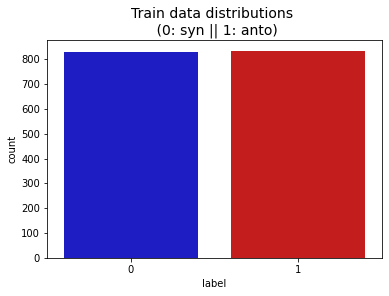

In [17]:
#load train data
anto = pd.read_table("../antonym-synonym set/Antonym_vietnamese.txt", sep=" ", header=None)
syn = pd.read_table("../antonym-synonym set/Synonym_vietnamese.txt", sep=" ", header=None).truncate(after=870)

anto["label"] = 1
syn["label"] = 0
display(anto.tail())
display(syn.tail())

data = pd.concat([syn, anto])
data.columns = ["Word1", "Word2", "label"]

# REMOVE LEAKAGE DATA
data = data[~data.set_index(['Word1','Word2']).index.isin(test_features.set_index(['Word1','Word2']).index)].reset_index().drop(columns="index")
features, _ = make_feature(data, drop_miss=True)


X = features.drop(columns=["Word1", "Word2", "first_emb", "second_emb", "label"])
y = np.array(features['label'].astype(np.int32)).reshape((-1, ))

display(X)
colors = ["#0101DF", "#DF0101"]

sns.countplot(x="label", data=data, palette=colors)
plt.title('Train data distributions \n (0: syn || 1: anto)', fontsize=14)
plt.show()

In [ ]:
sns.countplot(x="emb_miss", data=X, palette=colors)
plt.title('Number of missing embedding for train data \n (0: not miss || 1: miss)', fontsize=14)
plt.show()

In [19]:
from sklearn.linear_model import *
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import random 

kf = KFold(n_splits=5, shuffle=True)

cnt = 1
'''
clf = MLPClassifier(hidden_layer_sizes=(2, 1), 
                                       solver='adam', 
                                       learning_rate='invscaling', 
                                       learning_rate_init=0.2,
                                      max_iter=1000)
'''
# clfs = [make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear", max_iter=10000, class_weight="balanced",random_state=random.randint(0, 10000)))] * kf.n_splits               
clfs = [MLPClassifier()] * kf.n_splits               

result = list()

for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    
    clfs[cnt - 1].fit(X.iloc[train_index], y[train_index])
    score = f1_score(y[test_index], clfs[cnt - 1].predict(X.iloc[test_index]))
    print(score)
    result.append(score)
    cnt += 1


print("average F1-score: ", np.asarray(result).mean())

Fold:1, Train set: 776, Test set:194


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.8888888888888888
Fold:2, Train set: 776, Test set:194


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.8771929824561402
Fold:3, Train set: 776, Test set:194


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.8940092165898617
Fold:4, Train set: 776, Test set:194


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.851063829787234
Fold:5, Train set: 776, Test set:194
0.8888888888888888
average F1-score:  0.8800087613222027


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [20]:
labels_of_missings = labels_of_missings.reset_index(drop=True).values
print(labels_of_missings)

[0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1
 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0
 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 1]


In [21]:
labels_of_missings = labels_of_missings.reshape(-1)
print(labels_of_missings.shape)

(227,)


In [22]:
display(X_test)
np.set_printoptions(threshold=10000000)
print("out of fold result:")
for i in range(kf.n_splits):
    print(f1_score(y_test, clfs[i].predict(X_test)))

clfs[0].fit(X, y)
print("F1-score (fit all) with EMB_AVAILABLE ONLY: ")
logits = clfs[0].predict(X_test)
print(f1_score(y_test, logits))


print("F1-score (fit all) with FULL DATA (random logits for emb missing): ")
y_test_full = np.concatenate((y_test, labels_of_missings), axis=None)
logits_full = np.concatenate((logits, [0]*len(labels_of_missings)), axis=None)
print(f1_score(y_test_full, logits_full))


print(y_test_full)
print(logits_full)

,cos,norm_of_diff,pearson,spearman_rank,dot_product,euclidean,0,1,2,3,...,141,142,143,144,145,146,147,148,149,emb_miss
0,0.245766,16.834578,0.249734,0.271264,40.296856,-15.834578,0.464968,-0.580078,-1.960368,-0.103116,...,-0.402299,1.913816,0.985861,-1.884710,0.950788,0.893972,1.238505,-1.812881,-1.977862,0
1,0.171372,18.374029,0.171366,0.166683,34.760422,-17.374029,1.113018,1.765621,0.150326,-0.859085,...,0.492378,1.371746,1.377913,-0.647205,-0.486837,-0.193708,0.607562,-1.139292,-1.155154,0
2,0.088986,16.266695,0.088963,0.034229,12.025043,-15.266695,0.037391,0.722598,0.493901,1.180972,...,0.108250,-0.187398,-1.338901,-0.900232,-1.145505,1.226258,-0.379475,-0.493273,-0.036724,0
3,0.141662,16.180637,0.150397,0.135496,21.552877,-15.180637,-0.810381,-0.377639,1.287937,1.714588,...,0.072942,0.386578,0.325613,-0.238200,1.562420,-1.488866,-1.105518,3.139685,1.440905,0
5,-0.048281,15.954571,-0.048827,-0.042087,-5.739005,-14.954571,0.775089,0.034119,-0.582704,-0.962679,...,0.364164,-0.964517,-1.328818,0.072033,-1.438907,-2.559306,1.281982,0.080110,1.739585,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,0.475772,13.905120,0.472447,0.473182,87.042557,-12.905121,-0.338685,1.590143,0.460648,1.223749,...,-0.071784,0.031116,1.599446,-0.623854,0.343514,1.468286,1.263586,-1.069996,-2.291274,0
1395,0.629572,12.678332,0.628367,0.613533,136.498199,-11.678332,1.809414,-1.692015,-0.125298,1.332432,...,0.308102,0.414868,1.807029,-0.281104,0.788286,-0.186167,-0.427414,-0.591938,-0.179740,0
1397,0.075829,21.526340,0.086772,0.106567,19.005964,-20.526340,0.999721,-1.571221,0.734285,-0.873752,...,0.646405,0.058256,3.409161,-2.186149,0.017461,0.873159,0.158007,1.361819,0.191354,0
1398,0.415295,14.935099,0.414778,0.404510,75.847366,-13.935099,1.008996,0.967908,-1.912266,1.533196,...,0.874686,-0.147534,1.781836,-1.584086,-0.116408,0.111156,-0.342391,1.633662,-0.566177,0


out of fold result:
0.7475943745373796
0.7475943745373796
0.7475943745373796
0.7475943745373796
0.7475943745373796


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

F1-score (fit all) with EMB_AVAILABLE ONLY: 
0.7516981132075471
F1-score (fit all) with FULL DATA (random logits for emb missing): 
0.7186147186147187
[1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1
 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1
 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1
 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1
 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1
 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1
 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1
 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1
 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0
 0 1 0 1 1 0 1 1 1 0 1 1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
